In [479]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# import sympy as sp
# from numpy.random import default_rng
# from scipy.optimize import curve_fit
# from typing import Optional
# from lmfit.models import SineModel
%matplotlib inline

warnings.simplefilter('ignore')

In [480]:
c = 2.998e8 #光の速度
f = 920.4e6 #周波数
WAVE_LENGTH = c / f * 100 #理論波長
THETA_M = 34 * np.pi / 180
MAX_L = WAVE_LENGTH / (2 * np.sin(THETA_M))
L = 25
print(f'波長λ:{WAVE_LENGTH}, Lの最大値:{MAX_L}')
R=45
M = 3 #アンテナの数
K = 2 #信号の数
N = 100 #サンプル数
S = 30 * np.identity(K)
TRANSMISSION_POWER = 37.5

波長λ:32.57279443720122, Lの最大値:29.124828154140907


In [481]:
antenna_poplulation = 3
tag_population = 2
sample_count = 400
frequency = 920.4e6
antenna_space = 0.25
transmission_power = 37.5
light_speed = 2.998e8
wave_length = light_speed / frequency
angular_velocity = 2 * np.pi * frequency
theta_range = np.arange(-50, 50.001, 0.001)

In [482]:
data_dir = "data/"

file_name_list = [
    # "mock_data.csv"
    # "music_-150",
    # "music_-100",
    # "music_-50",
    # "music_0",
    # "music_50",
    "music_100",
    # "music_150",
]

data_dict = {}
data_dict = dict(zip(file_name_list, [pd.read_csv(data_dir + file + ".csv") for file in file_name_list]))

In [483]:
TARGET_TAGS = {
    "E200 4216 06D0 6410 02BC E161": 1,
    "E200 4216 0650 6410 02BC E159": 2
}

In [484]:
delta_phi_0 = 0

formatted_data_dict = {}

data_columns = [
    "tagId","frequency","samplingNumber"
]

for ant in range(1, M+1):
    data_columns.extend([f"antenna{ant}.rssi", f"antenna{ant}.phase", f"antenna{ant}.doppler"])

for key, df in data_dict.items():
    df = df[df["samplingNumber"] < sample_count]
    df = df[data_columns]
    df["x"] = key.split("_")[1]
    df = df[df["tagId"].isin(TARGET_TAGS.keys())]
    df["tagNumber"] = df["tagId"].map(lambda tag_id: TARGET_TAGS[tag_id])
    df.drop(columns="tagId", inplace=True)
    tag_data_list = []
    for tag_id, tag_number in TARGET_TAGS.items():
        tag_df = df[df["tagNumber"] == tag_number]
        tag_df = pd.DataFrame(IterativeImputer().fit_transform(tag_df), columns=df.columns)
        tag_data_list.append(tag_df)
    df = pd.concat(tag_data_list).sort_index()
    data_dict[key] = df
data_dict[file_name_list[0]].tail(4)

,frequency,samplingNumber,antenna1.rssi,antenna1.phase,antenna1.doppler,antenna2.rssi,antenna2.phase,antenna2.doppler,antenna3.rssi,antenna3.phase,antenna3.doppler,x,tagNumber
398,920.4,398.0,-54.5,5.325981,-18.6875,-59.000000,3.976078,-58.562500,-56.500000,2.644583,3.250000,100.0,2.0
398,920.4,398.0,-61.0,2.840932,13.8125,-59.000000,1.828505,102.500000,-65.922152,0.666454,-0.201501,100.0,1.0
399,916.8,399.0,-62.5,0.558369,-25.1875,-64.565843,1.070398,6.505928,-62.000000,3.939263,36.562500,100.0,1.0
399,916.8,399.0,-55.5,2.374602,-3.2500,-66.857641,2.536960,2.670267,-59.000000,1.417398,20.312500,100.0,2.0


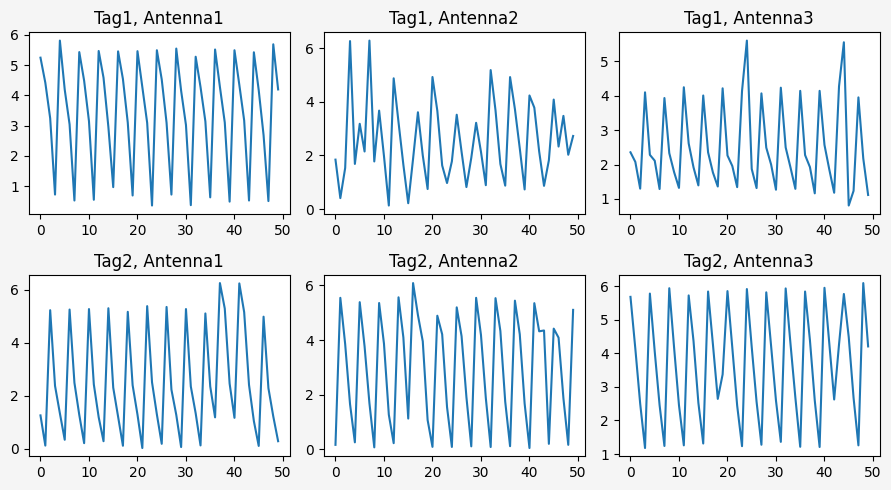

In [485]:
df = data_dict[file_name_list[0]][df["samplingNumber"] < 50]
df_tag = [df[df["tagNumber"] == tag_number] for tag_number in [1,2]]

fig, axes = plt.subplots(2, 3, tight_layout=True, facecolor="whitesmoke")
fig.set_size_inches(w=9, h=5)
x = range(0, 50)
for tag in range(tag_population):   
    for antenna in range(antenna_poplulation):
        axes[tag, antenna].plot(x, df_tag[tag][f"antenna{antenna+1}.phase"])
        axes[tag, antenna].set_title(f"Tag{tag+1}, Antenna{antenna+1}")
plt.show()

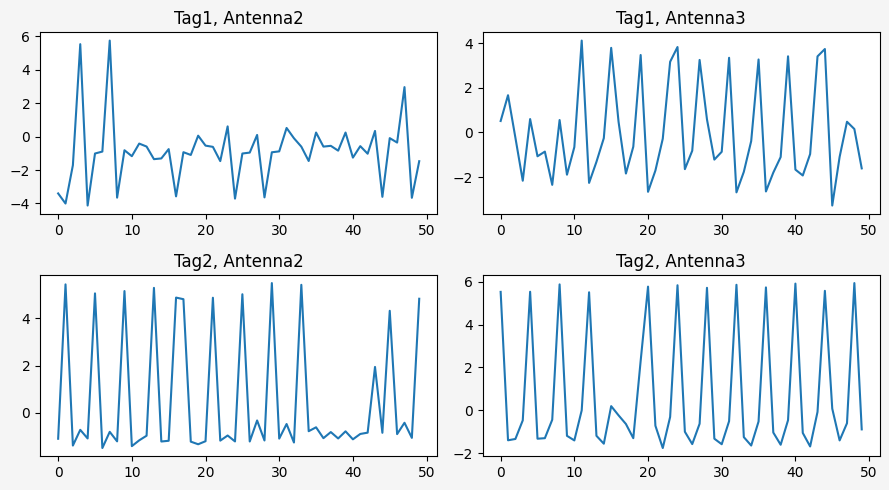

In [486]:
df["antenna2.phase_diff"] = df["antenna2.phase"] - df["antenna1.phase"]
df["antenna3.phase_diff"] = df["antenna3.phase"] - df["antenna2.phase"]
df_tag = [df[df["tagNumber"] == tag_number] for tag_number in [1,2]]
fig, axes = plt.subplots(2, 2, tight_layout=True, facecolor="whitesmoke")
fig.set_size_inches(w=9, h=5)
x = range(0, 50)
for tag in range(tag_population):   
    for antenna in range(antenna_poplulation-1):
        axes[tag, antenna].plot(x, df_tag[tag][f"antenna{antenna+2}.phase_diff"])
        axes[tag, antenna].set_title(f"Tag{tag+1}, Antenna{antenna+2}")
        axes[tag, antenna].set_yticks(np.arange(-6, 6.5, 1))
plt.show()

In [487]:
from classes.music import MUSIC

music = MUSIC(antenna_poplulation=antenna_poplulation, tag_population=tag_population, sampling_count=sample_count, antenna_space=antenna_space, wave_length=wave_length, tx_power=transmission_power, theta_range=theta_range)
music_spectrum = music.get_music_spectrum(data=data_dict[file_name_list[0]])
estimated_angles = music.peak_search(music_spectrum=music_spectrum)
print(estimated_angles)

[-6.966  6.966]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


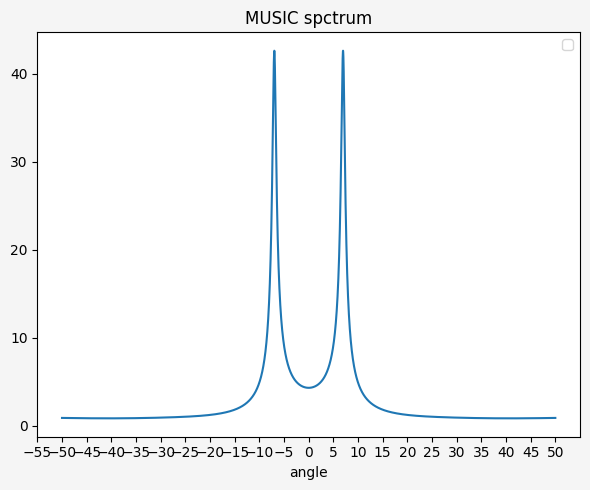

In [488]:
fig, ax = plt.subplots(tight_layout=True, facecolor="whitesmoke")
fig.set_size_inches(w=6, h=5)
x = theta_range
ax.plot(x, music_spectrum)
ax.set_xticks(np.arange(-55, 55, step=5))
ax.set_title("MUSIC spctrum")
ax.set_xlabel("angle")
ax.legend()
plt.show()